In [1]:
# import all modules 
import pandas as pd 
import numpy as np 
import sqlite3 
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from Tools.conversation import start_end_customers_filter
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 

#### 1. connect to the database 

In [2]:
con = sqlite3.connect('../../database/database(620).db')

In [3]:
query1 = """
    SELECT c.id_1, c.id_2, c.id_3, c.id_4, c.id_5, c.id_6, c.id_7, 
    c.airline_id, c.airline_name, c.conversation_opener, g.timestamp_ms
    FROM conversation as c, general_tweets as g
    WHERE g.id == c.id_1
"""
df = pd.read_sql_query(query1, con)

In [4]:
# df = df[df.airline_name=='KLM']
df = df.rename(columns={'timestamp_ms' : 'conversation_time'})

In [5]:
query2 = """SELECT id, sentiment_score FROM sentiment_table"""
df_sentiment = pd.read_sql_query(query2, con)

In [6]:
query3 = """SELECT id, timestamp_ms FROM general_tweets"""
df_timestamp = pd.read_sql_query(query3, con)

In [7]:
df_timestamp['timestamp_ms'] = pd.to_datetime(df_timestamp.timestamp_ms)

#### 2. get mean reply time 

In [8]:
# get timestamp for each tweet in each conversation
lst = ['id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7']
suffixes = ['_0', '_1', '_2', '_3', '_4', '_5', '_6' , '_7']
for idx in range(len(lst)):
    df = df.merge(right=df_timestamp, left_on=lst[idx], right_on='id', how='left', suffixes=(suffixes[idx], suffixes[idx + 1]))
    df.drop(columns='id', inplace=True)

In [9]:
df.rename(columns={'timestamp_ms' : 'timestamp_ms_7'}, inplace=True)

In [10]:
# get mean reply time for each row 
lst = []
for idx, row in df.iterrows():
    reply_time = []
    if row.conversation_opener == 'airline':
        reply_time.append((row.timestamp_ms_3 - row.timestamp_ms_2).seconds)
        reply_time.append((row.timestamp_ms_5 - row.timestamp_ms_4).seconds)
        reply_time.append((row.timestamp_ms_7 - row.timestamp_ms_6).seconds)
        reply_time = pd.Series(reply_time).dropna()
        mean_rep = sum(reply_time)/len(reply_time)
        lst.append(mean_rep)
    else:
        reply_time.append((row.timestamp_ms_2 - row.timestamp_ms_1).seconds)
        reply_time.append((row.timestamp_ms_4 - row.timestamp_ms_3).seconds)
        reply_time.append((row.timestamp_ms_6 - row.timestamp_ms_5).seconds)
        reply_time = pd.Series(reply_time).dropna()
        mean_rep = sum(reply_time)/len(reply_time)
        lst.append(mean_rep)

In [11]:
df['mean_reply_time'] = lst

#### 3. get the sentiment change score 

In [12]:
df = pd.concat([start_end_customers_filter(df), 
                df[['conversation_opener', 'conversation_time', 'airline_id', 'airline_name', 'mean_reply_time']].reset_index(drop=True)], 
               axis=1)

In [13]:
# fix the datatype
df['conversation_time'] = pd.to_datetime(df.conversation_time)
df_sentiment = df_sentiment.astype({
    'sentiment_score' : 'float64'
})

In [14]:
# get the sentiment score for open
df = df.merge(df_sentiment, left_on='open', right_on='id').drop(columns='id')
df.shape

(63707, 8)

In [15]:
# get the sentiment score for close 
df = df.merge(df_sentiment, left_on='close', right_on='id', suffixes=('_open', '_close')).drop(columns='id')
df.shape

(62015, 9)

In [16]:
df['sentiment_change'] = df['sentiment_score_close'] - df['sentiment_score_open']

In [17]:
df['positive'] = df['sentiment_change'] > 0

#### 4. filter by timestamp (depend on the teacher)

In [18]:
df_all = df.copy()

In [19]:
# change string timestamp_ms back to Timestamp object and rename column
df_all['conversation_time'] = pd.to_datetime(df_all.conversation_time)

In [20]:
# add attributes month and year 
month = []
year = []
for idx, row in df_all.iterrows():
    month.append(row.conversation_time.month)
    year.append(row.conversation_time.year)
df_all['month'] = month
df_all['year'] = year

In [24]:
df_all.groupby(['year', 'month']).count().index

MultiIndex([(2019,  5),
            (2019,  6),
            (2019,  7),
            (2019,  8),
            (2019,  9),
            (2019, 10),
            (2019, 11),
            (2019, 12),
            (2020,  1),
            (2020,  2),
            (2020,  3)],
           names=['year', 'month'])

In [25]:
# example teacher on 9-10 of 2019
n_month = [9, 10]
n_year = 2019
df = df_all[(df_all.month.isin(n_month)) & (df_all.year==n_year)].copy()
df.shape

(9636, 13)

#### 5. plotting

In [26]:
# standardize variables 
p = df[['mean_reply_time', 'sentiment_change']]
df_new = (p - p.mean())/p.std()
df_new = df_new[(df_new.sentiment_change < 3) & (df_new.sentiment_change > -3)]
df_new = df_new[(df_new.mean_reply_time < 3) & (df_new.mean_reply_time > -3)]

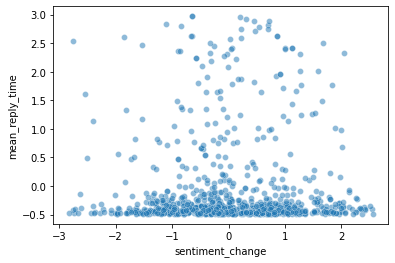

In [27]:
ax = sns.scatterplot(data=df_new.sample(1000), x='sentiment_change', y='mean_reply_time', alpha=0.5)

In [28]:
# correlation coefficient 
np.corrcoef(df['sentiment_change'], df['mean_reply_time'])

array([[1.        , 0.01155195],
       [0.01155195, 1.        ]])

<AxesSubplot:xlabel='sentiment_change', ylabel='mean_reply_time'>

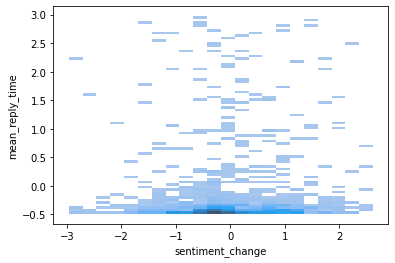

In [29]:
# make histogram
sns.histplot(data=df_new.sample(1000), x='sentiment_change', y='mean_reply_time')

#### 6. new idea

In [30]:
lst = []
for idx, row in df.iterrows():
    if (0 < row.mean_reply_time <= 60):
        lst.append('<1 minutes')
    elif (60 < row.mean_reply_time <= 600):
        lst.append('2-10 minutes')
    elif (600 < row.mean_reply_time <= 3600):
        lst.append('10-60 minutes')
    elif (3600 < row.mean_reply_time <= 3600*3):
        lst.append('1-3 hours')
    elif (3600*3 < row.mean_reply_time <= 3600*10):
        lst.append('3-10 hours')
    elif (3600*10 < row.mean_reply_time <= 3600*24):
        lst.append('10-24 hours')
    else:
        lst.append('more')

In [31]:
df['time_classification'] = lst

In [32]:
df[df.time_classification=='more'].shape

(0, 14)

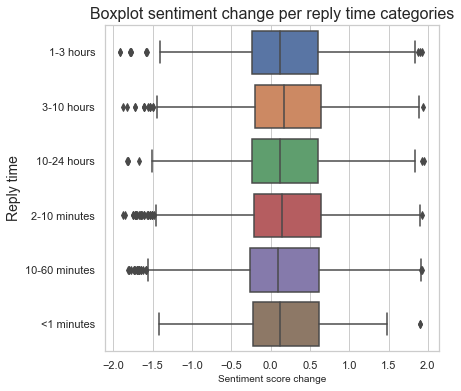

In [33]:
# plotting barchart 
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df[['sentiment_change', 'time_classification']], y='time_classification', x='sentiment_change', orient='h', ax=ax)
ax.set_title('Boxplot sentiment change per reply time categories', size=16)
ax.set_ylabel('Reply time', size=14)
ax.set_xlabel('Sentiment score change', size=10);